In [1]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

!cp /kaggle/input/2024-home-credit-public-repo/HomeCredit2024Banner.png .

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#EC0010; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #EC0010">Libraries</p>

In [2]:
import sys
sys.path.append('/kaggle/input/2024-home-credit-public-repo')

import subprocess
import numpy as np
import pandas as pd
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.auto import tqdm
from utils import RC, PALETTE, cS
from utils import plot_count

sns.set(rc=RC)

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

<p align="right">
  <img src="https://api.monosnap.com/file/download?id=KBbSBFnbD0Vdu1aI2I2dI5m7mgTSq8"/>
</p>

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#EC0010; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #EC0010">Overview</p>

The goal of this competition is to predict which clients are more likely to default on their loans. The evaluation will favor solutions that are stable over time.

Your participation may offer consumer finance providers a more reliable and longer-lasting way to assess a potential client’s default risk.

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#EC0010; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #EC0010">Data Schema</p>

In [3]:
!tree '/kaggle/input/home-credit-credit-risk-model-stability' -d 

ROOT = '/kaggle/input/home-credit-credit-risk-model-stability'
folders = ['csv_files/train', 'parquet_files/train', 'csv_files/test', 'parquet_files/test']
extensions = ['.csv',  '.parquet'] * 2

for dir_, ext in zip(folders, extensions):
    folder_path = Path(ROOT) / dir_
    num_files = len(list(folder_path.glob(f'*{ext}')))
    print(f"{cS.blk}Number of .csv files in: {'./' + dir_:>21}: {cS.blu}{num_files}{cS.res}")

/kaggle/input/home-credit-credit-risk-model-stability
|-- csv_files
|   |-- test
|   `-- train
`-- parquet_files
    |-- test
    `-- train

6 directories
Number of .csv files in:     ./csv_files/train: 32
Number of .csv files in: ./parquet_files/train: 32
Number of .csv files in:      ./csv_files/test: 36
Number of .csv files in:  ./parquet_files/test: 36


<p align="right">
  <img src="https://api.monosnap.com/file/download?id=QBYoGNfr4osgQfmrNPKGU4k05hUDkZ"/>
</p>

- There are **465** features and **436** respective descriptions in `feature_definitions.csv`. There are no missing descriptions so it means some feature might have same descriptions (for example description `Number of tax deductions` for features: `pmtcount_4527229L`, `pmtcount_4955617L`, `pmtcount_693L`).

- Various predictors were transformed, so to have the following notation for similar groups of transformations: **`P M A D T L`**

- Above you can see that `.csv` files duplicate `.parquet` ones. Ideally, we gotta check if they are really the same as mentioned in the competition data sections.

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#EC0010; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #EC0010">Evaluation</p>

<p>Submissions are evaluated using a gini stability metric. A gini score is calculated for predictions corresponding to each <code>WEEK_NUM</code>.</p>

$$
\text{Gini} = 2 \times \text{Area under ROC curve} - 1 
$$


A `linear regression model`, $$y = ax + b $$, is fit through the weekly Gini scores, and a <code>falling rate</code> is calculated as: $$min(0, a)$$
This is used to penalize models that drop off in predictive ability.

Finally, the variability of the predictions are calculated by taking the standard deviation of the residuals from the above linear regression, applying a penalty to model variablity.

The final metric is calculated as:

$$
\text{stability metric} = mean(gini) +88.0 \cdot min(0, a) -0.5 \cdot std(\text{residuals})
$$


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#EC0010; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #EC0010">Tables</p>

Alright, let's pick up some files. First, we definitely want to open the above mentioned `base` file. But, let's check the sizes.

In [4]:
def get_disk_usage(directory):
    cmd = f'du {directory}/* -h | sort -rh'
    result = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, text=True)
    output_lines = result.stdout.split('\n')

    # Extract file/directory names and sizes
    data = [line.split('\t') for line in output_lines if line]
    df = pd.DataFrame(data, columns=['size', 'path'])
    df['file_name'] = df.path.str.replace('train_|test_', '', regex=True).\
    apply(lambda x: Path(x).stem)
    return df

train_disk_usage = get_disk_usage(f'{ROOT}/csv_files/train').reset_index()
test_disk_usage = get_disk_usage(f'{ROOT}/csv_files/test')

train_disk_usage.reset_index().merge(test_disk_usage, on=['file_name'],
                                     how='outer', suffixes=['_train', '_test'])\
                                     .sort_values(by='index').drop(columns=['index'])

,level_0,size_train,path_train,file_name,size_test,path_test
17,0.0,2.9G,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/train/train_credit_bureau_a_2_5.csv,credit_bureau_a_2_5,4.0K,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/test/test_credit_bureau_a_2_5.csv
16,1.0,2.4G,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/train/train_credit_bureau_a_2_4.csv,credit_bureau_a_2_4,4.0K,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/test/test_credit_bureau_a_2_4.csv
15,2.0,2.3G,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/train/train_credit_bureau_a_2_3.csv,credit_bureau_a_2_3,4.0K,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/test/test_credit_bureau_a_2_3.csv
18,3.0,2.2G,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/train/train_credit_bureau_a_2_6.csv,credit_bureau_a_2_6,4.0K,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/test/test_credit_bureau_a_2_6.csv
21,4.0,1.6G,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/train/train_credit_bureau_a_2_9.csv,credit_bureau_a_2_9,4.0K,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/test/test_credit_bureau_a_2_9.csv
14,5.0,1.6G,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/train/train_credit_bureau_a_2_2.csv,credit_bureau_a_2_2,4.0K,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/test/test_credit_bureau_a_2_2.csv
6,6.0,1.5G,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/train/train_credit_bureau_a_1_1.csv,credit_bureau_a_1_1,8.0K,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/test/test_credit_bureau_a_1_1.csv
20,7.0,1.2G,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/train/train_credit_bureau_a_2_8.csv,credit_bureau_a_2_8,4.0K,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/test/test_credit_bureau_a_2_8.csv
7,8.0,949M,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/train/train_credit_bureau_a_1_2.csv,credit_bureau_a_1_2,4.0K,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/test/test_credit_bureau_a_1_2.csv
5,9.0,837M,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/train/train_credit_bureau_a_1_0.csv,credit_bureau_a_1_0,4.0K,/kaggle/input/home-credit-credit-risk-model-stability/csv_files/test/test_credit_bureau_a_1_0.csv


**Observations**:

- There are large train files. It looks we really need something powerful to handle them. Polars is a good choice, though I can still keep pandas for the small files.
- `static_0_2`, `credit_bureau_a_1_4`, `credit_bureau_a_2_11`, `applprev_1_2` are missing in the train folder.

In [5]:
PATH_BASE_TRAIN = f'{ROOT}/csv_files/train/train_base.csv'
PATH_BASE_TEST = f'{ROOT}/csv_files/test/test_base.csv'

train =  pd.read_csv(PATH_BASE_TRAIN)
test =   pd.read_csv(PATH_BASE_TEST)

display(train.head(3))
display(test.head(3))
display(train.dtypes)

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0


,case_id,date_decision,MONTH,WEEK_NUM
0,57543,2020-10-06,202010,92
1,57549,2020-10-06,202010,92
2,57551,2020-10-06,202010,92


case_id           int64
date_decision    object
MONTH             int64
WEEK_NUM          int64
target            int64
dtype: object

**Observations:**

Total of `case_id` is **1526659** with no dups. There few things I want to verify for the base file before I am done with it:
- Check if any dates are missing in `date_decision`;
- Check the target counts;
- Check the target distibutions against year/month of `date_decision`.

In [6]:
def get_date_interval_info(df, cS):
    df['date_decision'] = pd.to_datetime(df['date_decision'])
    date_delta = df['date_decision'].drop_duplicates().sort_values().diff()
    len_uniq_dates = len(df.date_decision.unique())
    print(
        f'\n{cS.blk}[INFO] Actual date range:  {cS.red}{date_delta.sum().days + 1} day(s).',
        f'\n{cS.blk}[INFO] Total unique dates: {cS.red}{len_uniq_dates} day(s).'
    )

    print(f'\n{cS.blk}[INFO] Min date: {cS.red}{df.date_decision.dt.date.min()}',
          f'\n{cS.blk}[INFO] Max date: {cS.red}{df.date_decision.dt.date.max()}')
    
get_date_interval_info(train, cS)
!printf  "\n----------Test data----------\n"
get_date_interval_info(test, cS)


[INFO] Actual date range:  644 day(s). 
[INFO] Total unique dates: 644 day(s).

[INFO] Min date: 2019-01-01 
[INFO] Max date: 2020-10-05

----------Test data----------

[INFO] Actual date range:  2 day(s). 
[INFO] Total unique dates: 2 day(s).

[INFO] Min date: 2020-10-06 
[INFO] Max date: 2020-10-07


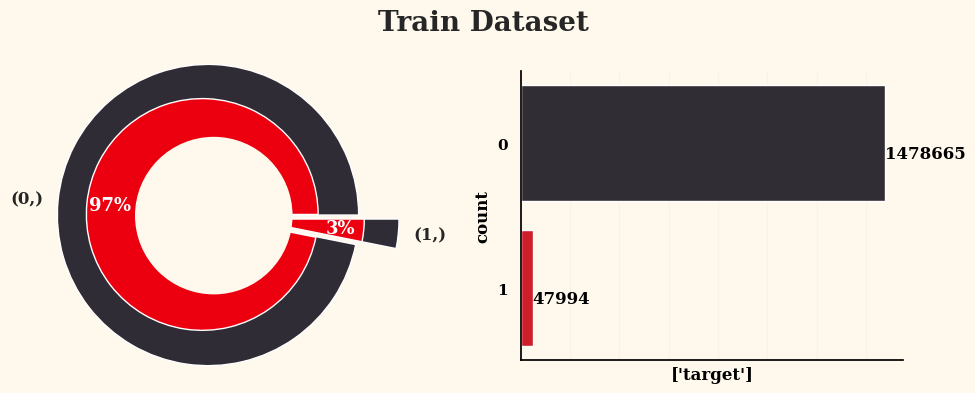

In [7]:
plot_count(train, ['target'])

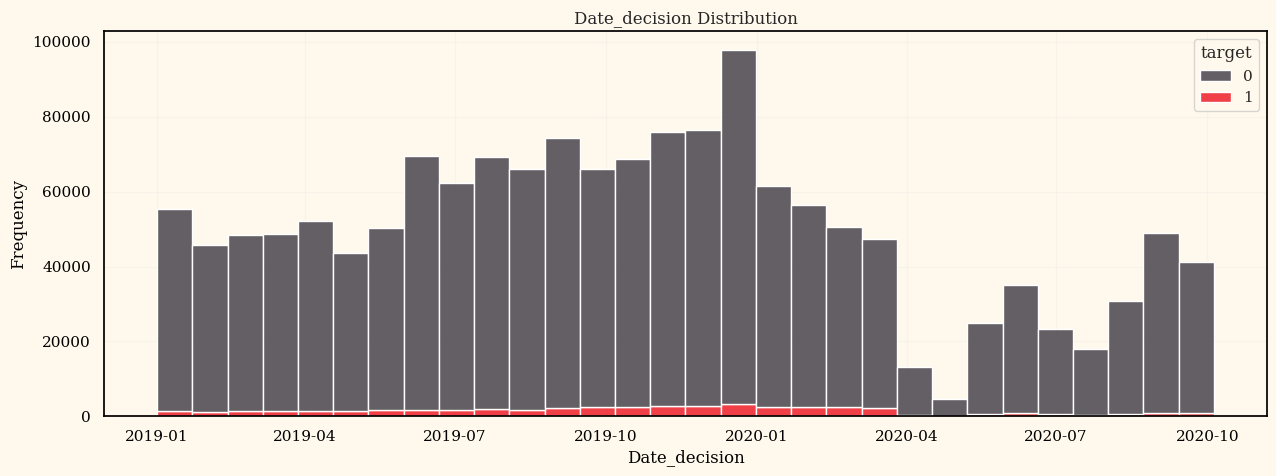

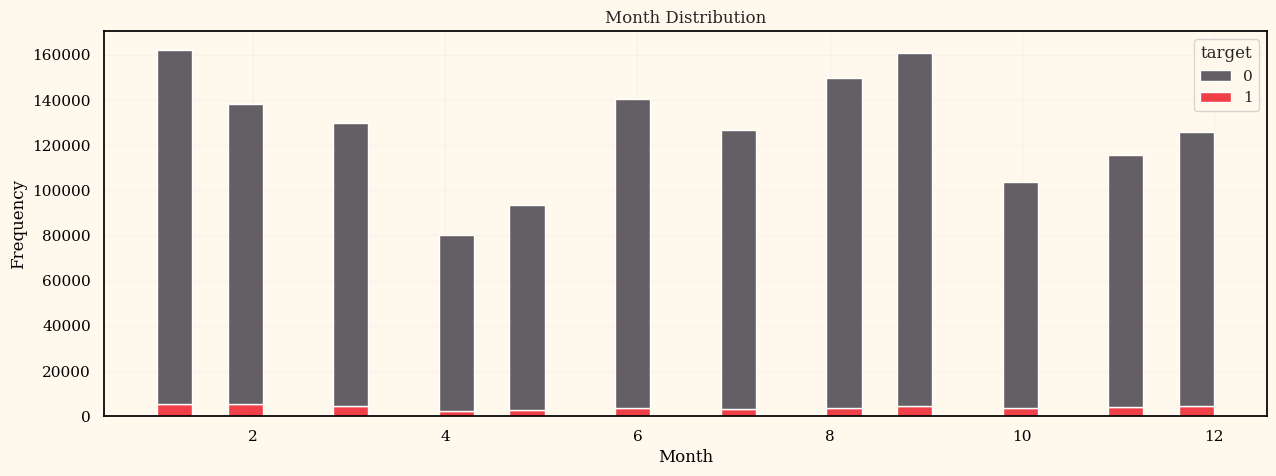

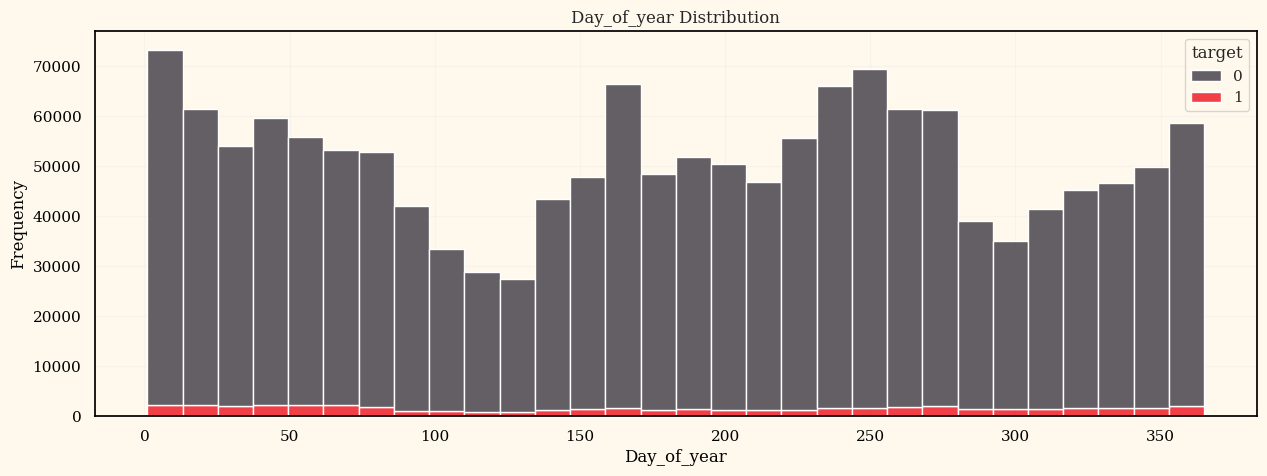

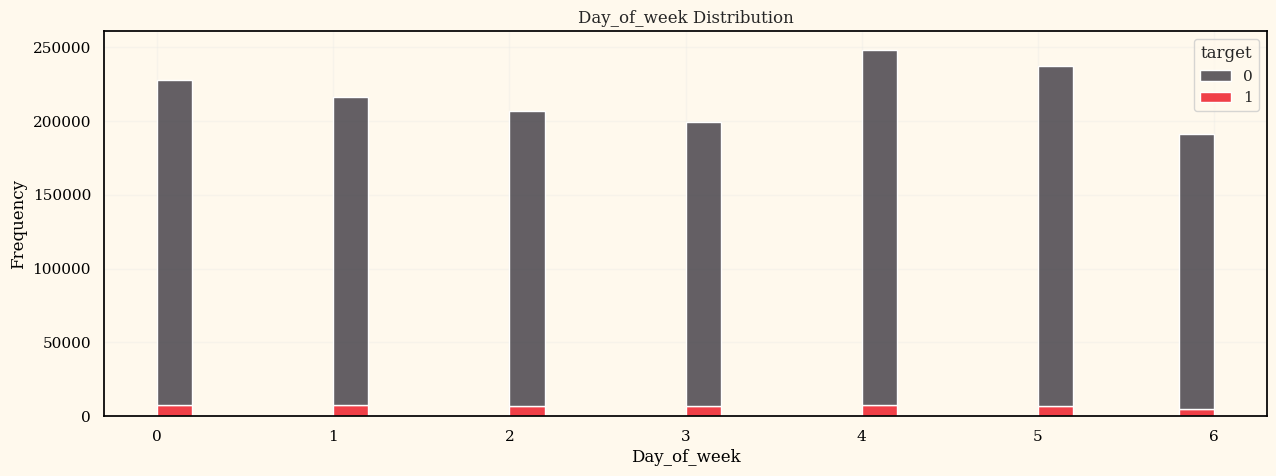

In [8]:
def plot_date_components_histogram_seaborn(df, component):
    fig = plt.figure(figsize=(15, 5))
    sns.histplot(data=df, x=component, bins=30, multiple="stack", kde=False, hue='target',
                 palette=[PALETTE[0], '#EC0010'])
    plt.title(f'{component.capitalize()} Distribution')
    plt.xlabel(component.capitalize())
    plt.ylabel('Frequency')
    plt.show()

# train['year'] = train.date_decision.dt.year-2019
train['month'] = train.date_decision.dt.month
train['day_of_year'] = train.date_decision.dt.day_of_year
train['day_of_week'] = train.date_decision.dt.day_of_week


plot_date_components_histogram_seaborn(train, 'date_decision')
plot_date_components_histogram_seaborn(train, 'month')
plot_date_components_histogram_seaborn(train, 'day_of_year')
plot_date_components_histogram_seaborn(train, 'day_of_week')

**Notes:**
- The dataset is extremely imbalanced, which is expectable for such domain.
- It seems covid-19 impacted the number of observations greatly.
- Interesting fact, the bank makes decision even on the weekends. Clearly, this process is automated and runs on a predefined schedule.

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#EC0010; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #EC0010">Null Values%</p>

In [9]:
# Code snippet for null values calculation can be found at 
# https://www.kaggle.com/datasets/sergiosaharovskiy/2024-home-credit-public-repo
# I don't want to waste 1 min 30 second of your life staring at the tqdm bar.
train_disk_usage = pd.read_csv('/kaggle/input/2024-home-credit-public-repo/files/train_disk_usage.csv')
train_disk_usage.head(3)

,size,path,file_name,depth,height,width,null_count,isna_%
0,2.9G,data/csv_files/train/train_credit_bureau_a_2_5.csv,credit_bureau_a_2_5,2,33053760,19,208735906,0.332371
1,2.4G,data/csv_files/train/train_credit_bureau_a_2_4.csv,credit_bureau_a_2_4,2,27025737,19,171502180,0.333994
2,2.3G,data/csv_files/train/train_credit_bureau_a_2_3.csv,credit_bureau_a_2_3,2,26563901,19,168378635,0.333612


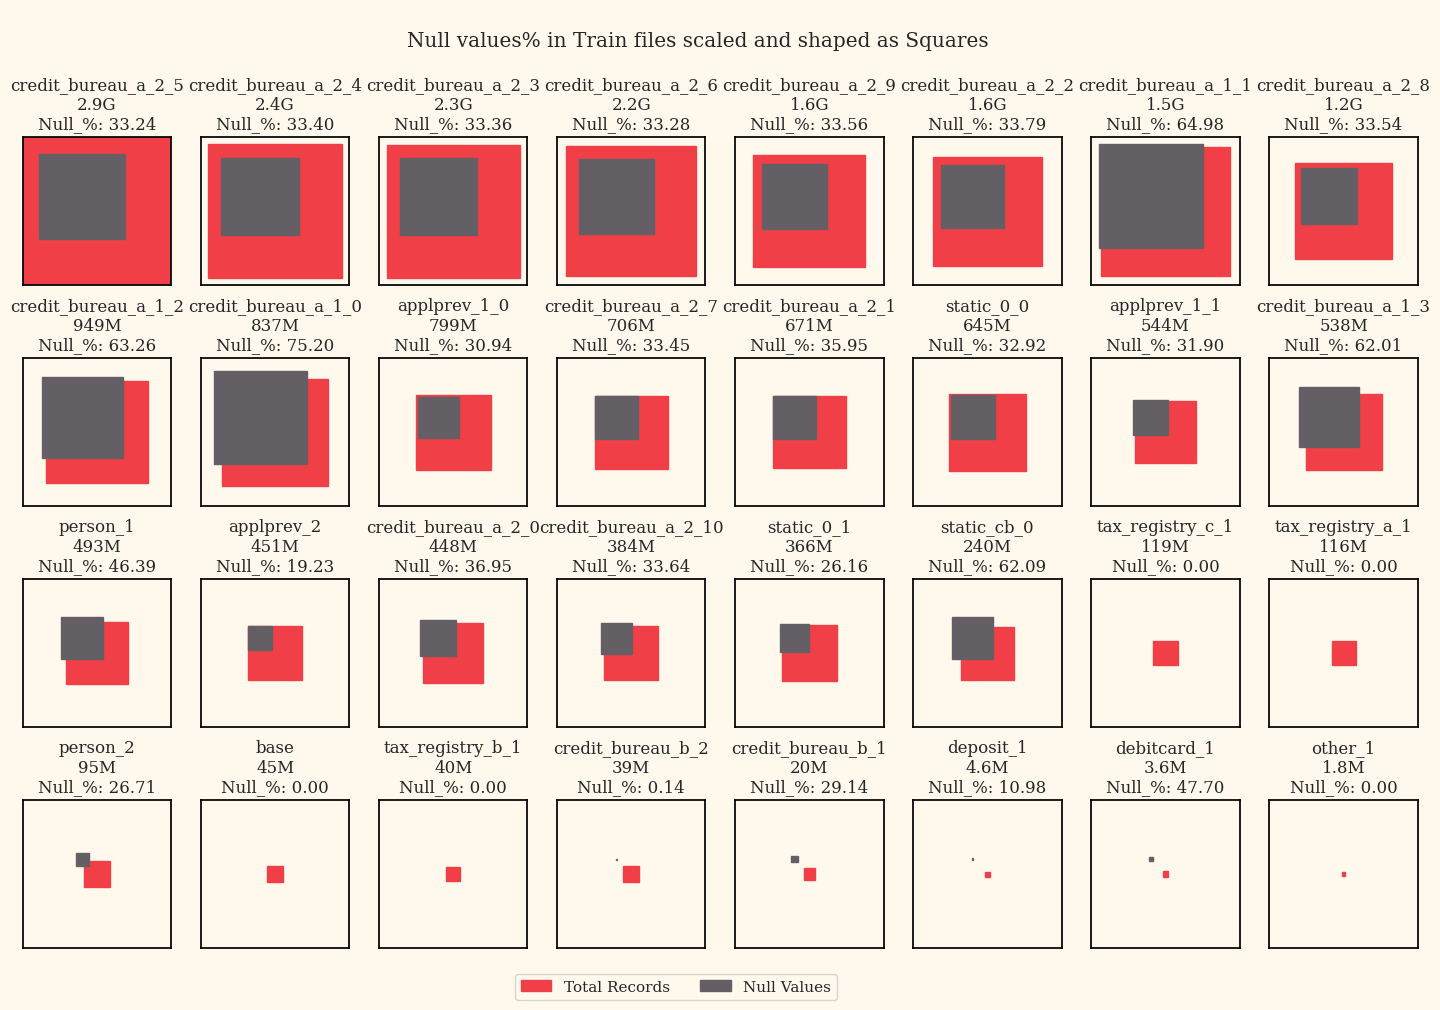

In [10]:
values = train_disk_usage['isna_%'].values.tolist()
total_area = train_disk_usage['height'] * train_disk_usage['width']
total_area_scaled = total_area / total_area.max()

rows = 4
cols = 8
fig, axs = plt.subplots(rows, cols, figsize=(18, 11))

for i, ax in enumerate(axs.flat):
    
    outer_square_side = np.sqrt(total_area_scaled[i])
    inner_square_side = np.sqrt(total_area_scaled[i]*values[i])

    # Add the small square inside the 1x1 image
    ax.add_patch(plt.Rectangle((0.5 - outer_square_side / 2, 0.5 - outer_square_side / 2),
                               outer_square_side, outer_square_side,
                               color='#F03F47', label='Total Records'))
    
    ax.add_patch(plt.Rectangle((0.4 - inner_square_side / 2, 0.6 - inner_square_side / 2),
                               inner_square_side, inner_square_side,
                               color='#645F64', label='Null Values'))

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_title(f'{train_disk_usage.file_name.iloc[i]}\n'
                 f'{train_disk_usage["size"].iloc[i]:}\nNull_%: {values[i]*100:.2f}')

plt.legend(bbox_to_anchor=(-4, -.4), loc='lower center', ncol=2)
plt.suptitle('\nNull values% in Train files scaled and shaped as Squares')

plt.tight_layout()
plt.show()

**How to read it**:
- The sizes of squares are scaled across all `train` files, where the biggest area is the biggest file;
- Red squares are normalized total counts of all records across all columns in the respective `train` file;
- Black squares are normalized total counts of **null** records across all columns in the respective `train` file.

For example, It means the `train` files are  **>30%** empty on average. The `credit_bureau` files are the biggest ones.

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#EC0010; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #EC0010">Distributions</p>

In [11]:
#TODO

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#EC0010; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #EC0010">Correlations</p>

In [12]:
#TODO

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#EC0010; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #EC0010">Hierarchical clustering</p>

In [13]:
#TODO

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#EC0010; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #EC0010">Base XGB Model</p>

In [14]:
#TODO